In [14]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

In [15]:
# Own implementations
%load_ext autoreload
%autoreload 2
from linear_model import *
from data_generation import *
from metric import *
from model_selection import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

## Lasso Regression on Franke Function

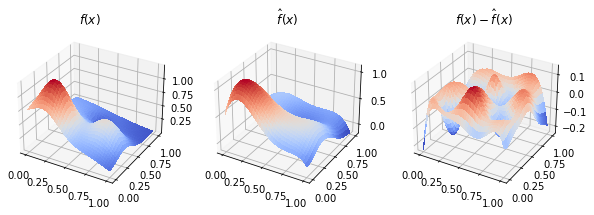

In [70]:
N_uniform = 40
x = np.linspace(0,1,N_uniform)
y = np.linspace(0,1,N_uniform)
X,Y = np.meshgrid(x,y)

kwargs = {"lw":2, 
          "cmap":cm.coolwarm, 
          "antialiased":False}

fig = plt.figure(figsize=(10,24))
ax_data = fig.add_subplot(131, projection='3d')
ax_fit = fig.add_subplot(132, projection='3d')
ax_diff = fig.add_subplot(133, projection='3d')

fXY = franke_function(X,Y)
ax_data.plot_surface(X, Y, fXY, **kwargs)
ax_data.set_title(r"$f(x)$")

# forming the cartesian product of x and y coordinates
xy = np.array([X,Y]).T.reshape(-1,2)
X_uniform = generate_design_matrix(xy[:,0], xy[:,1], p)
fit = ridge.predict(X_uniform)
fit = fit.reshape(N_uniform,N_uniform).T

ax_fit.plot_surface(X, Y, fit, **kwargs)
ax_fit.set_title(r"$\hat f(x)$")
ax_diff.plot_surface(X, Y, fit-fXY, **kwargs)
ax_diff.set_title(r"$f(x)-\hat f(x)$")

plt.show()

In [53]:
# Model parameters
degrees = np.arange(1,11)

# Hyperparamters
penalties = np.logspace(-3,-1,100)

# Data parameters
N = 600
x,y,z = random_x_y_franke(N)

# Resampling
B = 50

prediction_error_bs = np.empty((degrees.shape[0], penalties.shape[0]))
bias = np.empty((degrees.shape[0], penalties.shape[0]))
variance = np.empty((degrees.shape[0], penalties.shape[0]))

for j,penalty in enumerate(penalties):
    print(j, end=" ")
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=penalty, max_iter=1000000))
    for k,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        # We disable shuffling as we want to fit different models to the same trainings data. 
        # Note that random resampling (draw + replace) still takes place
        prediction_error_bs[k,j], bias[k,j], variance[k,j] = \
                predicition_error_bootstrap(squared_error, lasso, X, z, B=B, decomp=True, shuffle=False)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

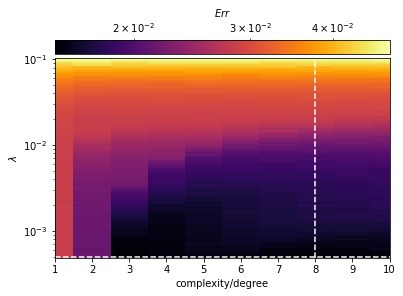

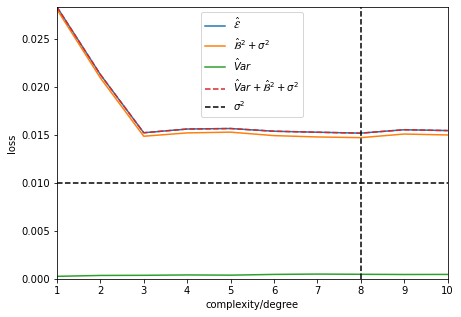

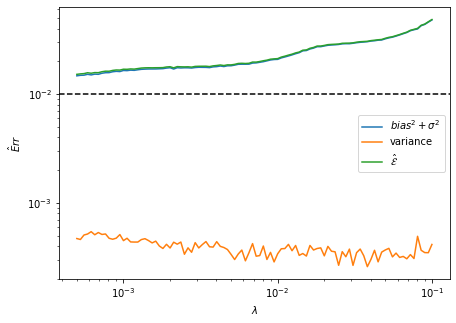

In [44]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

save = False
kwargs = {"lw":2, 
          "cmap":cm.inferno,
          "shading":"nearest",
          "norm":colors.LogNorm(vmin=prediction_error_bs[1:,:].min(), 
                                vmax=prediction_error_bs[1:,:].max()),
          "antialiased":False}

idx, idy = np.unravel_index(prediction_error_bs.argmin(), prediction_error_bs.shape)

fig,ax = plt.subplots()
ax.set_yscale("log")
im = ax.pcolormesh(degrees, penalties, prediction_error_bs.T, **kwargs)
ax.set_xlabel(r'complexity/degree')
ax.set_ylabel(r'$\lambda$')

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(r"$Err$")
cax.xaxis.set_label_position('top') 
ax.axhline(y=penalties[idy], c="w", ls="dashed")
ax.axvline(x=degrees[idx], c="w", ls="dashed")
ax.set_xlim([1,degrees[-1]])
plt.show()

fig, ax = plt.subplots(figsize=(7,5))

sigma = 0.1

ax.plot(degrees, prediction_error_bs[:,idy], label=r"$\hat \mathcal{E}$")
ax.plot(degrees, bias[:,idy], label=r"${\hat \mathcal{B}}^2 + \sigma^2$")
ax.plot(degrees, variance[:,idy], label=r"$\hat Var$")
ax.plot(degrees, variance[:,idy] + bias[:,idy], label=r"$\hat Var + {\hat \mathcal{B}}^2 + \sigma^2$", ls="dashed")
ax.set(xlabel="complexity/degree", ylabel=r"loss")
ax.axhline(sigma**2, ls="dashed",c="k", label=r"$\sigma^2$")
ax.axvline(degrees[np.argmin(prediction_error_bs[:,idy])], ls="dashed",c="k")
ax.set_xlim([degrees[0],degrees[-1]])
ax.set_ylim([0,np.max(prediction_error_bs[:,idy])])
ax.legend(*ax.get_legend_handles_labels())

if save:
    fig.savefig(save_dir + "test.pdf")


fig, ax = plt.subplots(figsize=(7,5))
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(penalties, bias[idx,:], label=r"$bias^2 + \sigma^2$")
ax.plot(penalties, variance[idx,:], label=r"variance")
ax.plot(penalties, prediction_error_bs[idx,:], label=r"$\hat \mathcal{E}$")

ax.set(xlabel=r"$\lambda$", ylabel=r"$\hat Err$")
ax.axhline(sigma**2, ls="dashed",color="k")
ax.legend(*ax.get_legend_handles_labels())

In [51]:
# Model parameters
degrees = np.arange(1,11)

# Hyperparamters
penalties = np.logspace(-3,-1,100)

# Data parameters
N = 600
x,y,z = random_x_y_franke(N)

# Cross Validation
folds = 10

prediction_error_kfold = np.empty((degrees.shape[0], penalties.shape[0]))
prediction_error_kfold_std = np.empty((degrees.shape[0], penalties.shape[0]))

for j,penalty in enumerate(penalties):
    print(j, end=" ")
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=penalty, max_iter=1000000))
    for k,p in enumerate(degrees):
        X = generate_design_matrix(x, y, p)
        prediction_error_kfold[k,j], prediction_error_kfold_std[k,j] = \
            prediction_error_CV(squared_error, lasso, X, z, nfolds=folds)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

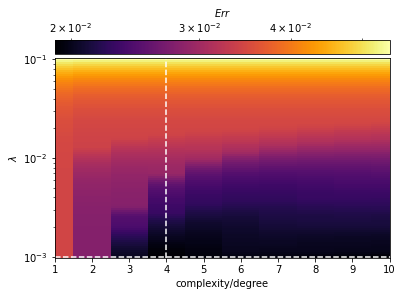

In [52]:
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

save = False
kwargs = {"lw":2, 
          "cmap":cm.inferno,
          "shading":"nearest",
          "norm":colors.LogNorm(vmin=prediction_error_kfold[1:,:].min(), 
                                vmax=prediction_error_kfold[1:,:].max()),
          "antialiased":False}

idx, idy = np.unravel_index(prediction_error_kfold.argmin(), prediction_error_kfold.shape)
fig,ax = plt.subplots()
ax.set_yscale("log")
im = ax.pcolormesh(degrees, penalties, prediction_error_kfold.T, **kwargs)
ax.set_xlabel(r'complexity/degree')
ax.set_ylabel(r'$\lambda$')

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="2%")
cb = fig.colorbar(im, cax=cax, orientation="horizontal")
cax.xaxis.set_ticks_position("top")
cax.set_xlabel(r"$Err$")
cax.xaxis.set_label_position('top') 
ax.axhline(y=penalties[idy], c="w", ls="dashed")
ax.axvline(x=degrees[idx], c="w", ls="dashed")
ax.set_xlim([1,degrees[-1]])
plt.show()

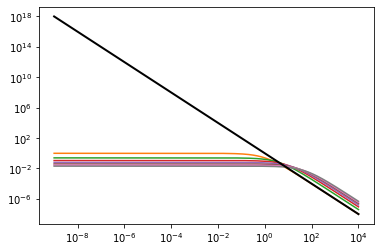

In [130]:
for i in range(8):
    plt.loglog(penalties, i**2/(i**2 + penalties)**2)
plt.loglog(penalties, 1.0/penalties**2, c="k", lw=2)
plt.show()